Use this notebook to run 1 denoiser step and get updated intermediate steps

In [1]:
import torch
from torch.testing import assert_close
from torch import allclose, nn, tensor
torch.set_printoptions(linewidth=200, precision=3)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

## Load the model

In [3]:
from diffusers import StableDiffusionXLPipeline
from diffusers import EulerDiscreteScheduler
from diffusers.models.controlnetxs import ControlNetXSModel
from diffusers.pipelines.controlnet_xs.pipeline_controlnet_xs_sd_xl import StableDiffusionXLControlNetXSPipeline

In [4]:
sdxl_pipe = StableDiffusionXLPipeline.from_single_file('weights/sdxl/sd_xl_base_1.0_0.9vae.safetensors').to(device)
cnxs = ControlNetXSModel.from_pretrained('weights/cnxs').to(device)

In [5]:
assert cnxs.control_model.down_blocks[1].attentions[0].transformer_blocks[0].attn1.heads==1

In [6]:
cnxs.base_model = sdxl_pipe.unet

Heidelberg uses `timestep_spacing = 'linspace'` in their scheduler, so let's do that as well

In [7]:
scheduler_cgf = dict(sdxl_pipe.scheduler.config)
scheduler_cgf['timestep_spacing'] = 'linspace'
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

# test it worked
sdxl_pipe.scheduler.set_timesteps(50)
assert sdxl_pipe.scheduler.timesteps[0]==999

# reset
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

In [8]:
cnxs_pipe = StableDiffusionXLControlNetXSPipeline(
    vae=sdxl_pipe.vae,
    text_encoder=sdxl_pipe.text_encoder,
    text_encoder_2=sdxl_pipe.text_encoder_2,
    tokenizer=sdxl_pipe.tokenizer,
    tokenizer_2=sdxl_pipe.tokenizer_2,
    unet=sdxl_pipe.unet,
    controlnet=cnxs,
    scheduler=sdxl_pipe.scheduler,
)

___

## Run

In [11]:
import torch
import random
import numpy as np
import cv2
from diffusers.utils import load_image
import matplotlib.pyplot as plt
from PIL import Image

def get_canny_image(im):
    image = np.array(im)
    image = cv2.Canny(image, 100, 200)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    return Image.fromarray(image)

def seed_everything(seed):
    # paper used deprecated `seed_everything` from pytorch lightning
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    
seed_everything(123456)

In [12]:
prompt = 'aerial view, a futuristic research complex in a bright foggy jungle, hard lighting'
neg_prompt = 'lowres, bad anatomy, worst quality, low quality'

guiding_image = load_image(
    "https://hf.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd_controlnet/hf-logo.png"
)
canny_image = get_canny_image(guiding_image)

In [13]:
def get_cnxs_image(ctrl_scale=0.95, control_guidance_end=1.0):
    seed_everything(123456)
    return cnxs_pipe(
        prompt, negative_prompt=neg_prompt,
        image=canny_image,
        controlnet_conditioning_scale=ctrl_scale,
        control_guidance_end=control_guidance_end
    ).images[0]

In [15]:
ims = [
    get_cnxs_image(control_guidance_end=0.001),
    get_cnxs_image(control_guidance_end=1.0)
]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

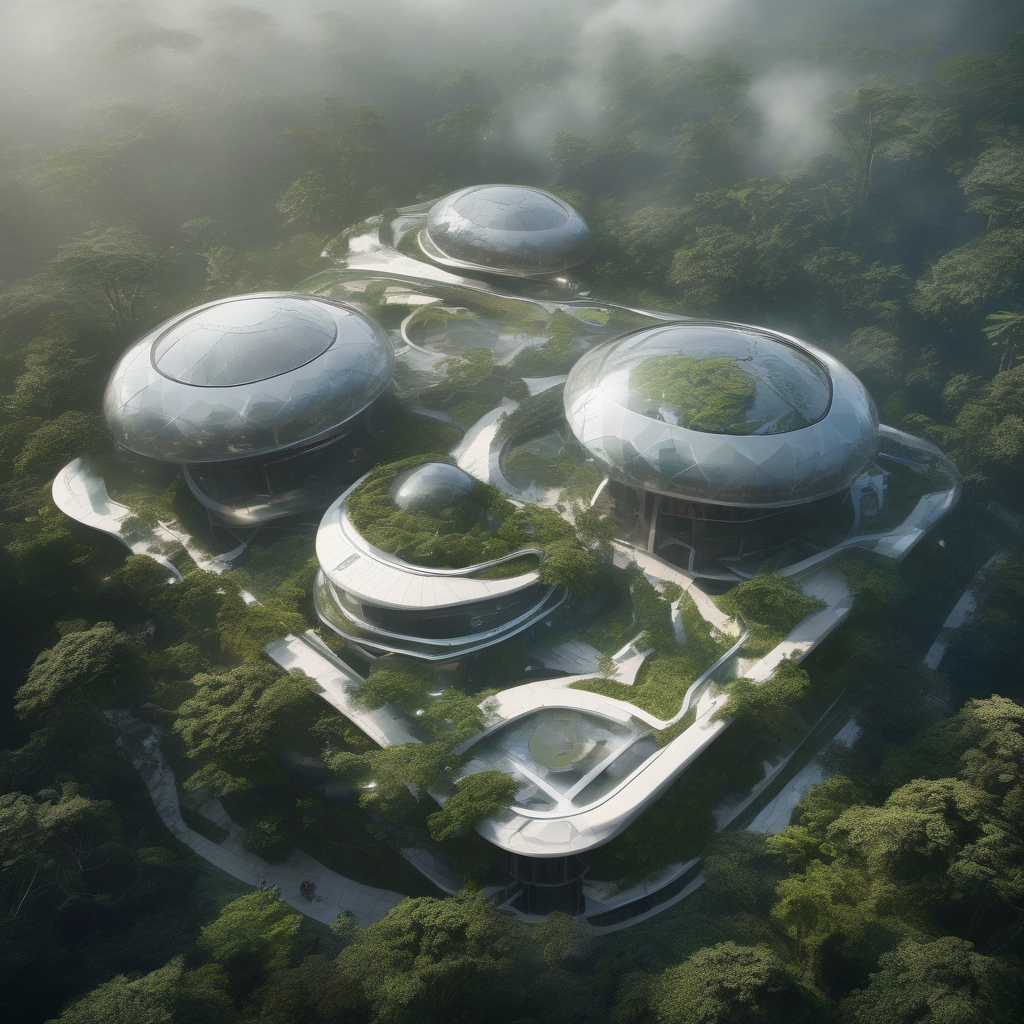

In [16]:
ims[0]

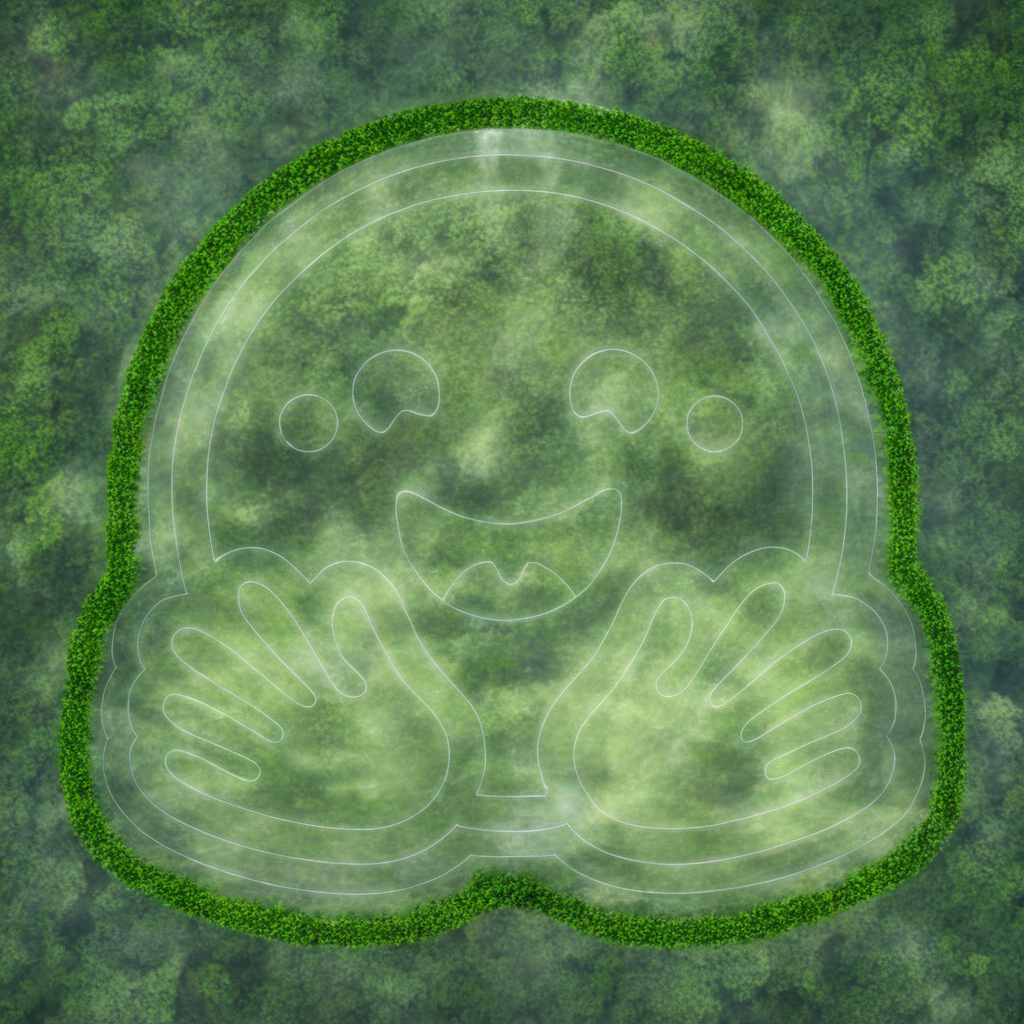

In [18]:
ims[1]